Should be final

In [1]:
from gym import Env
import gym
# import pygame
from gym.spaces import Discrete, Box, Dict
import numpy as np
import random

In [2]:
class WarehouseAgent:
    def __init__(self):
        self.GRID_DIM = [7, 6]

        self.agent_position = [1, 2]

        self.box_location = [4, 3]
        self.goal_location = [3, 1]
        self._action_to_direction = {
            0: np.array([-1, 0]),
            1: np.array([1, 0]),
            2: np.array([0, -1]),
            3: np.array([0, 1]),
        }
        self._ACTIONLOOKUP = {
            0: "move up",
            1: "move down",
            2: "move left",
            3: "move right",
            4: "push",
        }
        self.GRID_DIM = np.asarray(self.GRID_DIM)
        self.GRID = np.zeros(
            self.GRID_DIM
        )  # The Boundaries are the walls, so playing space is only [:-2,:-2]
        self.GRID[:, [0, -1]] = 1
        self.GRID[[0, -1], :] = 1
        self.GRID[[1, 2, 5], 3:5] = 1
        self.walls = 1
        self.action_space = Discrete(len(self._ACTIONLOOKUP.keys()))
        self.state_space = Discrete(self.GRID_DIM[0] * self.GRID_DIM[1])
        self.observation_space = Dict(
            {
                "agent": Box(
                    np.array([0, 0]),
                    np.array([self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1]),
                    shape=(2,),
                    dtype=int,
                ),
                "box": Box(
                    np.array([0, 0]),
                    np.array([self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1]),
                    shape=(2,),
                    dtype=int,
                ),
                "target": Box(
                    np.array([0, 0]),
                    np.array([self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1]),
                    shape=(2,),
                    dtype=int,
                ),
            }
        )
        self._agent_location = np.array(self.agent_position)
        self._box_location = np.array(self.box_location)
        self._target_location = np.array(self.goal_location)

    #         print(self.GRID)

    def step(self, action):
        self._prev_agent_location = None
        self._prev_box_location = None
        moved_box = False

        if action < 4:
            moved_player = self._move(action)
        else:
            moved_player, moved_box = self._push(action)

        done, reward = self.is_over()
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, done, info

    def render(self):
        rend = self.GRID.copy().astype(dtype="U1")
        rend[self._agent_location[0], self._agent_location[1]] = "A"
        rend[self._box_location[0], self._box_location[1]] = "B"
        rend[self._target_location[0], self._target_location[1]] = "T"
        if np.array_equal(self._target_location, self._box_location):
            rend[self._target_location[0], self._target_location[1]] = "D"
        return print(rend)

    def reset(self, seed=None, return_info=False, options=None):
        self._agent_location = np.array(self.agent_position)
        self._box_location = np.array(self.box_location)
        self._target_location = np.array(self.goal_location)

        observation = self._get_obs()
        info = self._get_info()
        return (observation, info) if return_info else observation

    def _get_obs(self):
        return {
            "agent": self._agent_location,
            "box": self._box_location,
            "target": self._target_location,
        }

    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._box_location - self._target_location, ord=1
            )
        }

    def _state_in_seq(self):
        m, n = self._agent_location
        seq = m * self.GRID.shape[1] + n
        return seq

    def _push(self, action):
        loc = self._box_location - self._agent_location
        #         print(f'loc{loc}, box :{self._box_location}, agent:{self._agent_location}')
        push_dir = None
        for idx, val in enumerate(self._action_to_direction.values()):
            if np.array_equal(loc, val):
                valid = True
                push_dir = idx
                break
            else:
                valid = False

        if valid:
            self._prev_agent_location = self._agent_location
            self._prev_box_location = self._box_location
            self._box_location = (
                self._box_location + self._action_to_direction[push_dir]
            )
            if self.GRID[self._box_location[0], self._box_location[1]] == 1:
                self._box_location = self._prev_box_location
                return False, False
            else:
                self._agent_location = (
                    self._agent_location + self._action_to_direction[push_dir]
                )
                return True, True

        return False, False

    def _move(self, action):
        self._prev_agent_location = self._agent_location
        self._prev_box_location = self._box_location
        self._agent_location = self._agent_location + self._action_to_direction[action]
        #             print(self.GRID[self._agent_location],self._agent_location,self.GRID)
        if self.GRID[self._agent_location[0], self._agent_location[1]] == 1:
            self._agent_location = self._prev_agent_location
            return False
        elif np.array_equal(self._agent_location, self._box_location):
            self._agent_location = self._prev_agent_location
            return False
        return True

    def is_over(self):
        if np.array_equal(
            self._box_location, self._target_location
        ):  # checking if the box is at the target already
            done = True
            reward = 0
        elif (
            sum(
                a := np.array(
                    [
                        True
                        if self.GRID[
                            (self._box_location + val)[0], (self._box_location + val)[1]
                        ]
                        == 1
                        else False
                        for val in self._action_to_direction.values()
                    ]
                )
            )
            >= 1
        ):
            # basically checking if there are atleast 1 wall adjacent to box
            if sum(a) > 1:
                done = True
                reward = -100 ## Reward for getting stuck at wall -1 not a good option####
            elif sum(a) == 1:
                if ~(self._box_location - self._target_location).all():
                    done = False
                    reward = -1
                    return done, reward
                else:
                    #                 print(a)
                    direc = np.where(a == True)
                    #                 print(direc)
                    direc = direc[0][0]
                    left = self._box_location + self._action_to_direction[direc]
                    right = left.copy()
                    if direc in [0, 1]:
                        count = 0
                        while (self.GRID[left[0], left[1]] != 0) and (
                            self.GRID[right[0], right[1]] != 0
                        ):

                            left = np.clip(
                                left + self._action_to_direction[2],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            right = np.clip(
                                right + self._action_to_direction[3],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            count += 1
                            if count >= self.GRID_DIM[1]:
                                done = True
                                reward = -100 #box getting stuck
                                return done, reward
                                break
                    #                         right = right + self._action_to_direction[3]

                    else:
                        count = 0
                        while (self.GRID[left[0], left[1]] != 0) and (
                            self.GRID[right[0], right[1]] != 0
                        ):
                            left = np.clip(
                                left + self._action_to_direction[1],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            right = np.clip(
                                right + self._action_to_direction[0],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            count += 1
                            if count >= self.GRID_DIM[0]:
                                done = True
                                reward = -100 #getting stuck
                                return done, reward
                                break

                    done = False
                    reward = -1
                    return done, reward
        #         np.where([True if self.GRID[(self._box_location + val)[0], (self._box_location + val)[1] ] == 1 else False for val in self._action_to_direction.values() ] == True)[0][0]: # gotta check if the box is not adjacent to 2 walls but still is terminating state like the boundary walls
        else:
            done = False
            reward = -1
        return done, reward

In [ ]:
env  = WarehouseAgent()

In [ ]:
env.state_space.n

In [ ]:
def ep_soft(env):
    policy = np.ones([env.state_space.n,env.action_space.n])/5
    return policy
    
def gen_epsiode(env,policy):
    env.reset()
    done = False
    episode = []
    count = 0
    while not done and count<100:
        s = env._state_in_seq()
        prob = policy[s]
        action = np.random.choice(range(env.action_space.n),p=prob)
        observation, reward, done ,_ = env.step(action)
        episode.append([s,action,reward])
        count+=1
    return episode
def visit_to_s(env,episode,Returns):
    visited = []
    R = None
    for ind,s in enumerate(episode):
        if s not in visited:
            act = s[1]
            for p in episode[ind:]:
                print(p,R)
                R+=p[2]
            Returns[ind,act] = R
        else:
            continue
    return Returns
def Q_val(Returns):
    Q = np.average(Returns,axis=2)
    return Q
            
def MC(env,ep = 0.1):
    Q = np.zeros([env.state_space.n,env.action_space.n])
    Returns = np.zeros([env.state_space.n,env.action_space.n])
    policy = ep_soft(env)
    for k in range(1):
        episode = gen_epsiode(env,policy)
        print(len(episode))
        Returns  = visit_to_s(env,episode,Returns)
        Q = Q_val(Returns)
        for ind,step in enumerate(episode):
            a_star = np.argmax(Q,axis = 1)
            for a in range(env.action_space.n):
                if a == a_star:
                    policy[step[0],step[a]] = (1 - ep) + (ep/env.action_space.n)
                else:
                    policy[step[0],step[a]] = (ep/env.action_space.n)
            
    
    return policy


In [ ]:
env = WarehouseAgent()

In [ ]:
# policy = ep_soft(env)
# gen_epsiode(env,policy)
MC(env)

In [ ]:
np.average(np.zeros([env.state_space.n,env.action_space.n])+1,axis=1)
# np.zeros([env._state_in_seq(),env.action_space.n])+1
# env.state_space.n
a = np.array([[[2,2],[1,1]],[[2,2],[5,10]]])
a

In [ ]:
np.argmax(np.average(a,axis=2),axis = 1)

In [ ]:
np.random.choice([1,2,3,5],p = [0.1,0.5,0.3,0.1])

In [ ]:
env =WarehouseAgent()

In [ ]:
env.render()

In [ ]:
env = WarehouseAgent()
# n_actions = env.action_space.n
s = env._state_in_seq()
# env = gym.make('Taxi-v2')
n_states, n_actions = env.state_space.n, env.action_space.n
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(Q, epsilon, n_actions, s, train=False):
    """
    @param Q Q values state x action -> value
    @param epsilon for exploration
    @param s number of states
    @param train if true then no random actions selected
    """
    if train or np.random.rand() < epsilon:
        action = np.argmax(Q[s, :])
    else:
        action = np.random.randint(0, n_actions)
    return action

def sarsa(env,alpha, gamma, epsilon, episodes, max_steps, n_tests, render = False, test=False):
    """
    @param alpha learning rate
    @param gamma decay factor
    @param epsilon for exploration
    @param max_steps for max step in each episode
    @param n_tests number of test episodes
    """

    timestep_reward = []
    for episode in range(episodes):
        print(f"Episode: {episode}")
        total_reward = 0
        env.reset()
        s = env._state_in_seq()
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0
        done = False
        while not done:
#             if render:
#                 env.render()
            t += 1
            obs, reward, done, info = env.step(a)
            s_ = env._state_in_seq()
            total_reward += reward
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            if done:
                Q[s, a] += alpha * ( reward  - Q[s, a] )
            else:
                Q[s, a] += alpha * ( reward + (gamma * Q[s_, a_] ) - Q[s, a] )
            s, a = s_, a_
            if done:
                if render:
                    print(f"This episode took {t} timesteps and reward {total_reward}")
                timestep_reward.append(total_reward)
                break
        print(done,t)
    if render:
        print(f"Here are the Q values:\n{Q}\nTesting now:")
    if test:
        test_agent(Q, env, n_tests, n_actions)
    return timestep_reward

In [ ]:
alpha = 0.4
gamma = 0.999
epsilon = 0.9
episodes = 3000
max_steps = 2500
n_tests = 20
timestep_reward = sarsa(env,alpha, gamma, epsilon, episodes, max_steps, n_tests)
print(timestep_reward)

In [ ]:
act = np.argmax(Q,axis=1)
env.reset()
print(env._state_in_seq())
for a in act[8:]:
    print(env.step(a))

In [3]:
env = WarehouseAgent()
n_states, n_actions = env.state_space.n, env.action_space.n
Q = np.zeros((n_states, n_actions))
def ep_greedy(env,Q,epsilon=0.9):
    seq = env._state_in_seq()
    if np.random.random()<epsilon:
#         print(Q[seq,:])
        x=(Q[seq,:]!=0).all()
        print(x)
#         print(x,'here')
        if x :           
            action = np.argmax(Q[seq,:])
#             print('h')
        else:
            action = np.where(Q[seq,:]==0)[0]
#             print(action)
            action=action[0]
#             print('why')
    else:
        action = np.random.randint(env.action_space.n)
#     print(action)
    return action
def Sarsa(env,alpha, gamma, epsilon, episodes, max_steps):
    timestep_reward = []
    for ep in range(episodes):
        env.reset()
        done = False
        total_reward = 0        
        curr_state = env._state_in_seq()
        curr_a = ep_greedy(env,Q)
        t = 0
        while not done :
            obs, reward, done, info = env.step(curr_a)
            next_state = env._state_in_seq()
            total_reward+= reward
            next_act = ep_greedy(env,Q)
    #         s = curr_state 
    #         s_ = next_state 
    #         a_ = next_act
            t+=1

            Q[curr_state, curr_a] += alpha * ( reward + (gamma * Q[next_state, next_act] ) - Q[curr_state, curr_a] )
            curr_state = next_state
            curr_a = next_act
    #         print(reward)
#             env.render()
        print(t)
        timestep_reward.append(total_reward)
    return timestep_reward

In [4]:
q = np.zeros(5)
# q[1]= 1
(q!=0).all()


False

In [5]:
# Q

In [6]:
env = WarehouseAgent()
alpha = 0.2
gamma = 0.9
epsilon = 0.9
episodes = 200
max_steps = 1e4
# n_tests = 20
timestep_reward = Sarsa(env,alpha, gamma, epsilon, episodes, max_steps)
# print(timestep_reward)

91
24
105
251
115
58
174
52
93
88
74
85
75
115
45
354
70
96
112
45
58
165
60
97
98
66
79
89
390
1063
570
834
291
2678
800
268
159
108
55
216
114
7
949
142
169
79
55
136
22
41
28
20
13
72
151
40
71
33
173
986
725
10430
15898
4910
46077
56225
42050
913
25692
4516
4114
116422
48048
8709
305346
444020
123608
67142
178269
1273991
352799
82533
109830
92217
109900
8724
6311
4780
36717
27652
10421
6023
3176
2534
748
890
13337
2098
3651
2223
5456
2764
3437
1260
922
762
3163
3738
368
153
226
4113
5057
1681
1302
269
272
3292
3970
5655
22956
5109
62318
33153
15059
7839
59465
891
12845
796
4463
3497
484
1516
2766
6689
3843
2850
1340
16421
339
33731
3405
6882
40348
22342
4990
40367
10737
21630
18842
2424
2044
14692
24672
26286
5840
41453
2916
21050
27144
15189
71417
11134
7373
11998
16737
913
37474
12984
4374
25216
484542
186691
241660
1115368
16819
975827
15489
3161
15151
6568
13565
17229
47136
100750
6420
42064
18942
4847
18125
14818
15698
4380
30547
58845
4203
4630
11773
33863


In [7]:
env.render()

[['1' '1' '1' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'D' '0' '0' '0' '1']
 ['1' 'A' '0' '0' '0' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]


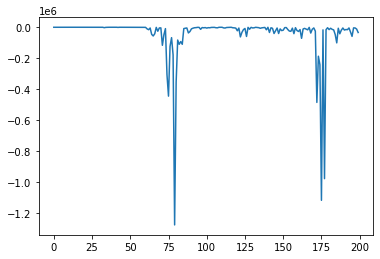

In [8]:
import matplotlib.pyplot as plt
plt.plot(timestep_reward)

In [9]:
max(timestep_reward)

-12

In [10]:
Q

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [-10.00047899, -10.0010953 , -10.00047919, -10.00012365,
        -10.00047265],
       [-10.00012204, -10.03993339, -10.00020939, -10.00024301,
        -10.00026372],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.   

In [11]:
plot = np.full(Q.shape[0],'-',dtype='U1')
dire = {0:'^',1:'v',2:'<',3:'>',4:'#'}
# plot = [0]*Q.shape[0]
for index,sa in enumerate(Q):
    if (sa.any()):
        plot[index] =  dire[np.argmax(sa)]
plot = plot.reshape(env.GRID_DIM)
plot

array([['-', '-', '-', '-', '-', '-'],
       ['-', '>', '^', '-', '-', '-'],
       ['-', '^', '<', '-', '-', '-'],
       ['-', '^', '>', '>', 'v', '-'],
       ['-', '^', 'v', '>', '>', '-'],
       ['-', '#', '<', '-', '-', '-'],
       ['-', '-', '-', '-', '-', '-']], dtype='<U1')

In [12]:
env_t = WarehouseAgent()
done = False
while not done:
    state = env_t._state_in_seq()
    action = np.argmax(Q[state,:])
    obs, reward, done, info = env_t.step(action)
    
#     print('------------')
    if done:
        break
env_t.render()

KeyboardInterrupt: 

In [ ]:
a = [1,1]
# a[2] = 3
Q.shape[0]

In [ ]:
for act in

In [ ]:
act = np.argmax(Q,axis=1)
env.reset()
print(env._state_in_seq())
for a in act[8:]:
    print(env.step(a))

In [ ]:
env.reset()
env.render()

In [ ]:
env.step(1)
env.render()

In [ ]:
env.step(1)
env.render()

In [ ]:
env.step(3)
env.render()

In [ ]:
env.step(3)
env.render()

In [ ]:
env.step(1)
env.render()

In [ ]:
env.step(4)
env.render()

In [ ]:
env.step(4)
env.render()

In [ ]:
env.step(4)
# env.render()

# Q learning

In [130]:

def ep_greedy(env,Q,action_count,epsilon=0.9):
    seq = env._state_in_seq()
    if np.random.random()<epsilon:
#         print(Q[seq,:])
#         x = action_count[seq]
#         x = (x!=0).all()
#         print(x,action_count[seq])
        x=(Q[seq,:]!=0).all()
#         print(x,'here')
        if x :           
            action = np.argmax(Q[seq,:])
#             print('h')
        else:
            action = np.where(action_count[seq]==0)[0]
#             print(action)
            action=action[0]
#             print('why')
    else:
        action = np.random.randint(env.action_space.n)
#     print(action)
    return action
def QL(env,alpha, gamma, epsilon, episodes):
    timestep_reward = []
    for ep in range(episodes):
        env.reset()
        done = False
        total_reward = 0        
        curr_state = env._state_in_seq()

#         curr_a = ep_greedy(env,Q)
        t = 0
        while not done :
            curr_state = env._state_in_seq()
            curr_a = ep_greedy(env,Q,action_count)
            action_count[curr_state,curr_a]+=1
            obs, reward, done, info = env.step(curr_a)
            next_state = env._state_in_seq()
            total_reward+= reward
#             next_act = ep_greedy(env,Q)
            t+=1

            Q[curr_state, curr_a] += alpha * ( reward + (gamma * np.max(Q[next_state]) ) - Q[curr_state, curr_a] )
            curr_state = next_state
#             curr_a = next_act
    #         print(reward)
#             env.render()
        print(t)
        timestep_reward.append(total_reward)
    return timestep_reward

In [150]:
env = WarehouseAgent()
env.render()
# env = WarehouseAgent()
n_states, n_actions = env.state_space.n, env.action_space.n
Q = np.zeros((n_states, n_actions))
action_count = np.zeros((env.state_space.n, env.action_space.n))
alpha = 0.01
gamma = 0.9
epsilon = 0.9
episodes = 500
# max_steps = 1e4
# n_tests = 20
timestep_reward = QL(env,alpha, gamma, epsilon, episodes)
# print(timestep_reward)

[['1' '1' '1' '1' '1' '1']
 ['1' '0' 'A' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'T' '0' '0' '0' '1']
 ['1' '0' '0' 'B' '0' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]
76
92
122
114
235
248
225
41
251
225
142
197
291
38
293
351
160
247
157
246
72
182
133
136
304
203
222
106
519
54
214
164
56
258
119
201
117
96
67
150
50
296
317
173
230
161
300
154
112
156
106
196
117
184
127
219
153
167
157
178
312
135
169
221
65
30
183
348
70
82
224
314
126
184
73
100
175
353
85
137
77
110
223
314
106
216
186
96
131
190
151
164
187
260
101
162
130
203
106
37
132
197
51
173
148
189
140
302
190
197
146
74
61
333
241
124
60
80
87
110
262
82
261
168
165
146
219
225
411
31
300
42
165
48
154
125
130
34
137
208
103
178
179
108
236
310
116
35
158
164
199
44
178
175
220
87
334
164
179
90
121
15
208
317
100
178
109
298
125
168
131
50
165
191
129
72
255
107
167
226
140
265
250
122
233
139
309
170
66
114
123
156
311
112
201
228
210
218
244
134
188
122
34
255
134
103
130
105
97
178
81
128
271

[['1' '1' '1' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'D' '0' '0' '0' '1']
 ['1' 'A' '0' '0' '0' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]


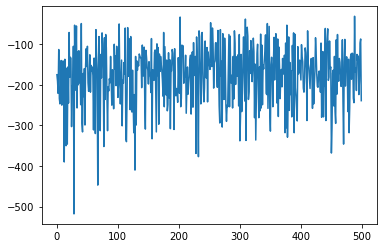

In [151]:
env.render()
import matplotlib.pyplot as plt
plt.plot(timestep_reward)

In [149]:
Q

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [  -9.99973248,   -9.99972941,   -9.99973126,   -9.99973007,
          -9.99973073],
       [  -9.99973858,   -9.99970138,   -9.9997353 ,   -9.9997342 ,
          -9.99973576],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0

Q end

In [102]:
env = WarehouseAgent()
#Defining the hyper parameters
alpha = 0.8
gamma = 0.9
epsilon = 0.9
total_episodes = 500

#Initializing the Q-table with 0
Q = np.zeros((env.state_space.n,env.action_space.n))  # (total no. of states * total no. of actions)
Q.shape
#Function to choose the next action from a state
def choose_action(state):
    action=0
    # epsilon greedy
    p = np.random.random()
    if p < epsilon:  # choose random action among 4 actions
        x = (Q[state,:]!=0).all()
        if x:
            action = np.argmax(Q[state,:])
        else:
            action = np.where(Q[state,:]==0)[0]
            action = action[0]
            
    else:
        action = np.random.randint(env.action_space.n)
        
    return action
    
# Function to update the Q-table
def Qupdate(current_state, current_action, next_state, reward, next_max):
    Q[current_state, current_action] = Q[current_state, current_action] + alpha*(reward + (gamma * next_max)- Q[current_state, current_action])
    #Initializing the reward
episodes_reward = []  # total sum of rewards in a episode, for each episodes

# Starting the Q-learning learning
for episode in range(total_episodes):
    env.reset()
    current_state = env._state_in_seq()    # initial state i.e reset to intial state for each episode  # env.reset()
    total_reward = 0
    t = 0
    done = False        # done is for terminated or not
    # loop in the episode until the environment not terminated
    while not done:
        current_action = choose_action(current_state)  # initial action for this initial_state
        # Getting the next state,reward
        observation, reward, done, info = env.step(current_action)   # Take one step in the environment
        next_state = env._state_in_seq()
        
        # max (S',ai) value
        next_max = np.max(Q[next_state])
        
        # Q table update
        Qupdate(current_state, current_action, next_state, reward, next_max)
        
        
        current_state = next_state

        total_reward += reward
        t+=1
    print(t)
    # At the end of learning process i.e termination
    episodes_reward.append(total_reward)

76
106
75
129
79
133
97
90
124
153
202
79
262
128
92
186
194
247
190
139
32
206
285
274
232
232
238
295
55
41
105
148
55
63
110
375
150
320
309
272
123
46
119
630
42
197
45
689
118
297
15
173
13
327
274
18
375
123
510
437
169
108
1025
49
882
349
464
1121
323
52
88
129
207
391
577
82
68
1222
148
882
206
17
281
105
296
222
51
31
395
44
268
693
8
1185
155
156
149
336
162
493
434
221
212
204
20
1693
864
122
532
1259
1049
1975
34
57
968
48
398
900
752
221
1363
114
1137
189
303
104
638
113
141
125
250
703
527
774
339
671
388
292
665
714
78
65
75
1588
507
1148
189
389
442
498
488
342
200
721
732
75
345
123
377
561
478
595
259
327
56
940
802
43
295
154
121
463
1753
581
324
495
151
98
442
580
276
207
962
152
414
536
595
230
65
56
1014
124
559
26
184
351
75
456
533
57
583
4
9
56
876
207
319
675
46
341
74
190
15
89
194
256
1238
101
536
292
19
960
96
236
541
595
1282
51
140
501
440
233
45
84
299
585
607
464
111
77
413
126
154
97
35
234
194
365
784
26
110
236
24
23
702
484
384
7
78
61
251
271
220
9

[['1' '1' '1' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'T' '0' '0' '0' '1']
 ['1' '0' '0' 'A' 'B' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]


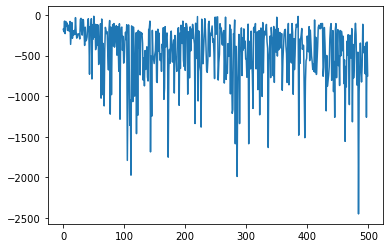

In [103]:
env.render()
import matplotlib.pyplot as plt
plt.plot(episodes_reward)

In [104]:
max(episodes_reward)

-14

MC onpolicy first visit

In [129]:
env = WarehouseAgent()
def create_random_policy(env):
    policy = {}
    for key in range(0, env.state_space.n):
        current_end = 0
        p = {}
        for action in range(0, env.action_space.n):
            p[action] = 1 / env.action_space.n
        policy[key] = p
    return policy
policyx = create_random_policy(env)
def create_state_action_dictionary(env, policy):
    Q = {}
    for key in policy.keys():
        Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
    return Q
Qx = create_state_action_dictionary(env, policyx)
# policyx

In [152]:
def run_game(env, policy, display=True, returns=True):
    env.reset()
    episode = []
    returns = []
    finished = False
    while not finished:
        s = env._state_in_seq()
        timestep = []
        timestep.append(s)
#         n = random.uniform(0, sum(policy[s].values()))
#         top_range = 0
#         for prob in policy[s].items():
#             top_range += prob[1]
#             if n < top_range:
#                 action = prob[0]
#                 break
        action = ep_greedymc(env,policy,action_count,epsilon=0.9)
        #         print(action)
        obs, reward, finished, info = env.step(action)
        timestep.append(action)
        timestep.append(reward)

        episode.append(timestep)
        returns.append(reward)

    #         print(state, reward)


    if returns:
        return episode, returns
    return episode, None

In [159]:
n_states, n_actions = env.state_space.n, env.action_space.n
Q = np.zeros((n_states, n_actions))
policy = np.ones((n_states, n_actions))/n_actions
Returns = np.zeros((n_states, n_actions))
action_count = np.zeros((n_states, n_actions))
def ep_greedymc(env,policy,action_count,epsilon=0.9):
    seq = env._state_in_seq()
    if np.random.random()<epsilon:
#         print(Q[seq,:])
        x = action_count[seq]
        x = (x!=0).all()
#         print(x,action_count[seq])
        x=(policy[seq,:]!=0).all()
#         print(x,'here')
        if x :           
            action = np.argmax(policy[seq,:])
#             print('h')
        else:
            action = np.where(action_count[seq]==0)[0]
#             print(action)
            action=action[0]
#             print('why')
    else:
        action = np.random.randint(env.action_space.n)
#     print(action)
    return action
def monte_carlo_e_soft(env, policy,episodes = 10,gamma=0.9, epsilon=0.01, plot_graph=False):
    
  # Create an empty dictionary to store state action values
#     Q = create_state_action_dictionary(env, policy)  # Empty dictionary for storing rewards for each state-action pair
    returns = {}  # 3.
    rx = []
    for ep in range(episodes):  # Looping through episodes
        G = 0  # Store cumulative reward in G (initialized at 0)
        episode, rew = run_game(
            env=env, policy=policy, display=False
        )  # Store state, action and value respectively
        rx.append(np.sum(rew))
        # for loop through reversed indices of episode array.
        # The logic behind it being reversed is that the eventual reward would be at the end.
        # So we have to go back from the last timestep to the first one propagating result from the future.

        for i in reversed(range(0, len(episode))):
            s_t, a_t, r_t = episode[i]
            state_action = (s_t, a_t)
            G = gamma*G + r_t  # Increment total reward by reward on current timestep

            if not state_action in [(x[0], x[1]) for x in episode[0:i]]:  #
                if returns.get(state_action):
                    returns[state_action].append(G)
                else:
                    returns[state_action] = [G]

                Q[s_t][a_t] = sum(returns[state_action]) / len(
                    returns[state_action]
                )  # Average reward across episodes

#                 Q_list = list(
#                     map(lambda x: x[1], Q[s_t].items())
#                 )  # Finding the action with maximum value
#                 indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)]
                max_Q = random.choice(indices)

#                 A_star = max_Q  # 14.
                A_star = np.argmax(Q[s_t])

                for a in policy[s_t]:
                    #                     print(policy[s_t])  # Update action probability for s_t in policy
                    if a == A_star:

                        policy[s_t][a] = (1- epsilon+ (epsilon/env.action_space.n) #np.abs(np.sum(np.array(list(policy[s_t].values()))))
                            )
                        
                    else:
                        policy[s_t][a[0]] = epsilon /env.action_space.n #np.abs(np.sum(np.array(list(policy[s_t].values())))                        )  # abs(sum(policy[s_t].values()))
    print("N")
    if plot_graph:
        print("Y")
        cumulative_average = np.cumsum(np.array(rx)) / (np.arange(episodes) + 1)
        plt.plot(
            cumulative_average, label=r"Gradient Bandit ($\alpha$ = " + f"{epsilon})"
        )
        plt.title(f"Average rewards over {episodes} timesteps", fontsize=14)
        plt.xlabel("Timesteps", fontsize=14)
        plt.ylabel("Average Rewards", fontsize=14)

    return policy

In [160]:
env = WarehouseAgent()
env.reset()
policy = monte_carlo_e_soft(env, episodes=1,policy=policy)
policy

KeyboardInterrupt: 

## MC

In [162]:
def create_random_policy(env):
    policy = {}
    for key in range(0, env.state_space.n):
        current_end = 0
        p = {}
        for action in range(0, env.action_space.n):
            p[action] = 1 / env.action_space.n
        policy[key] = p
    return policy
def create_state_action_dictionary(env, policy):
    Q = {}
    for key in policy.keys():
        Q[key] = {a: 0.0 for a in range(0, env.action_space.n)}
    return Q
# cre
# Q
def run_game(env, policy, display=True, returns=True):
    env.reset()
    episode = []
    returns = []
    finished = False
    while not finished:
        s = env._state_in_seq()
        #         print(s)  # env._get_obs()["agent"][0] * env._get_obs()["agent"][1]
        #         if display:
        #             clear_output(True)
        #             print(env.render())
        #             sleep(1)

        timestep = []
        timestep.append(s)
        n = random.uniform(0, sum(policy[s].values()))
        top_range = 0
        for prob in policy[s].items():
            top_range += prob[1]
            if n < top_range:
                action = prob[0]
                break
        #         print(action)
        state, reward, finished, info = env.step(action)
        timestep.append(action)
        timestep.append(reward)

        episode.append(timestep)
        returns.append(reward)

    #         print(state, reward)

    if display:
        clear_output(True)
        print(env.render())
        sleep(1)
    if returns:
        return episode, returns
    return episode, None
def test_policy(policy, env, r=10):
    wins = 0
    r = 100
    for i in range(r):
        w, _ = run_game(env, policy, display=True)
        w = w[-1][-1]
        if w == 0:
            wins += 1
    return wins / r
def monte_carlo_e_soft(env, episodes=100, policy=None, epsilon=0.01, plot_graph=True):
    if not policy:
        policy = create_random_policy(
            env
        )  # Create an empty dictionary to store state action values
    Q = create_state_action_dictionary(
        env, policy
    )  # Empty dictionary for storing rewards for each state-action pair
    returns = {}  # 3.
    rx = []
    for _ in range(episodes):  # Looping through episodes
        G = 0  # Store cumulative reward in G (initialized at 0)
        episode, rew = run_game(
            env=env, policy=policy, display=False
        )  # Store state, action and value respectively
        rx.append(np.sum(rew))
        # for loop through reversed indices of episode array.
        # The logic behind it being reversed is that the eventual reward would be at the end.
        # So we have to go back from the last timestep to the first one propagating result from the future.

        for i in reversed(range(0, len(episode))):
            s_t, a_t, r_t = episode[i]
            state_action = (s_t, a_t)
            G += r_t  # Increment total reward by reward on current timestep

            if not state_action in [(x[0], x[1]) for x in episode[0:i]]:  #
                if returns.get(state_action):
                    returns[state_action].append(G)
                else:
                    returns[state_action] = [G]

                Q[s_t][a_t] = sum(returns[state_action]) / len(
                    returns[state_action]
                )  # Average reward across episodes

                Q_list = list(
                    map(lambda x: x[1], Q[s_t].items())
                )  # Finding the action with maximum value
                indices = [i for i, x in enumerate(Q_list) if x == max(Q_list)]
                max_Q = random.choice(indices)

                A_star = max_Q  # 14.

                for a in policy[s_t].items():
                    #                     print(policy[s_t])  # Update action probability for s_t in policy
                    if a[0] == A_star:

                        policy[s_t][a[0]] = (
                            1
                            - epsilon
                            + (
                                epsilon
                                / np.abs(np.sum(np.array(list(policy[s_t].values()))))
                            )
                        )
                    else:
                        policy[s_t][a[0]] = epsilon / np.abs(
                            np.sum(np.array(list(policy[s_t].values())))
                        )  # abs(sum(policy[s_t].values()))
    print("N")
    if plot_graph:
        print("Y")
        cumulative_average = np.cumsum(np.array(rx)) / (np.arange(episodes) + 1)
        plt.plot(
            cumulative_average, label=r"Gradient Bandit ($\alpha$ = " + f"{epsilon})"
        )
        plt.title(f"Average rewards over {episodes} timesteps", fontsize=14)
        plt.xlabel("Timesteps", fontsize=14)
        plt.ylabel("Average Rewards", fontsize=14)

    return policy

In [164]:
env = WarehouseAgent()
env.reset()
policy = monte_carlo_e_soft(env, episodes=5)

KeyboardInterrupt: 